# Welcome to NameWeave (MLP) - Activations, Gradients & Batch Normalization

Let's rearrange our last code from <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave%20-%20Multi%20Layer%20Perceptron.ipynb">NameWeave - Multi Layer Perceptron</a> file, to make it look a little bit more tidier first.

# Installing Dependencies

In [1]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib

# Importing Libraries

In [2]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\avhis\AppData\Local\Temp\ipykernel_304\3082457058.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading Dataset


In [3]:
words = open("Datasets/Indian_Names.txt").read().splitlines()
words = [word.lower() for word in words]

In [4]:
len(words)

53982

# Building Vocabulary


In [5]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:", characters)
print("STOI:", stoi)
print("ITOS", itos)
# We define a common vocabulary size
vocabularySize = len(stoi)
print("Vocabulary Size:", vocabularySize)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocabulary Size: 27


# Building Dataset

In [8]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * blockSize
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

# We can check the numbers
print("Total Examples:",len(words)) # 100%
print("Training Examples:",len(words[:numberOfInputs1])) # 80%
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2])) # 10%
print("Test Examples:",len(words[numberOfInputs2:])) # 10%

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


# Neural Network Initialization - Weights, Biases & Parameters

In [10]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator)
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

# Neural Network - Training, Back-Propagation & Updation

In [16]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
print("Minibatch Loss:", loss)

      0/ 200000: 25.4462
  10000/ 200000: 2.3372
  20000/ 200000: 2.0521
  30000/ 200000: 2.4103
  40000/ 200000: 1.9892
  50000/ 200000: 2.7770
  60000/ 200000: 2.4457
  70000/ 200000: 2.1623
  80000/ 200000: 2.1746
  90000/ 200000: 1.9633
 100000/ 200000: 1.9765
 110000/ 200000: 1.9889
 120000/ 200000: 1.8822
 130000/ 200000: 2.2266
 140000/ 200000: 1.8511
 150000/ 200000: 1.9462
 160000/ 200000: 1.9257
 170000/ 200000: 2.2852
 180000/ 200000: 2.0552
 190000/ 200000: 2.0097
Minibatch Loss: tensor(1.5459, grad_fn=<NllLossBackward0>)


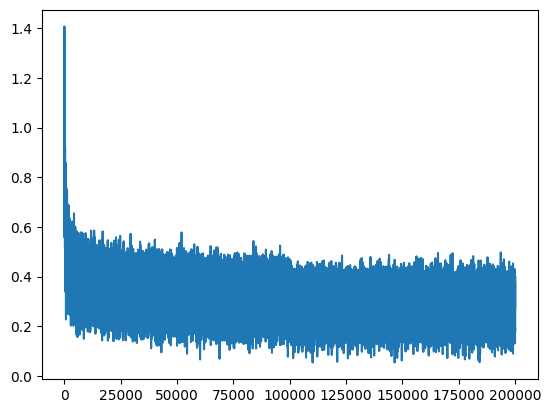

In [17]:
plt.plot(losses)

Once again, we see a steep descent for the first few iterations

Remeber how I said,\
**We tend to calculate the loss on a test-split very cautiously and very few times,** \
**Because, every single time we evaluate our test loss, the model learns something from the split..** \
**So, we basically end up overfitting the test-split as well.** \
**Therefore, we are only allowed to test the loss on test-split very less times.**

Keeping exactly that in mind, we make our next snippet...

In [20]:
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerStates = torch.tanh(concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  

# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.9471455812454224
Validation Loss:1.9744399785995483


Here,
```python
@torch.no_grad()
```
is a *decorator* in Python, and in this context, it's used to disable gradient tracking within the decorated function. \
Gradient tracking is a feature in PyTorch that keeps track of operations for automatic differentiation (backpropagation). \
Disabling it within the function is often useful when you don't want to compute gradients, such as during *inference* or when evaluating the model's performance.

# Sampling from our model

In [21]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)

# We will define a generator to give the same result on your machine, as of my machine
numberOfWordsToSample = 20

# We iterate over the number of words we want to predict
for _ in range(numberOfWordsToSample):
    # We define a output list to append the next character and print it at the end
    output = []
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * blockSize

    # We will now iterate over each word's characters
    while True:
        # We would create an output embedding that would be based on the block
        embedding = embeddingLookUpMatrix[torch.tensor([block])]
        # We would be doing a foward pass on the above embedding vector 
        hiddenLayerStates = torch.tanh(embedding.view(1, -1) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
        logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
        probabilities = F.softmax(logits, dim=1)
        # We can now sample the next character
        index = torch.multinomial(probabilities, num_samples=1, generator=generator).item()
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
        # We then append the sampled character to the output
        output.append(index)
        # If we hit '.' end token, we will break out from the loop
        if index == 0:
            break
    # We print generated name out
    print(''.join(itos[index] for index in output))

kundunya.
hita.
niriaiththan.
man.
karidevani.
jamirishnu.
achelve.
meenardraseka.
kaasagaanin.
jaivaadhunavihan.
kirini.
nirth.
banthana.
mevmullimenoshitrayaanithevanoja.
laya.
kobigi.
satra.
udhavavaraikravalgish.
suswnishivanutharuchadashithantayan.
meraja.


# Understanding Losses

### Looking into our initial Loss

This is me recording the losses I get for the very first time I run this notebook for myself.\
You may get different losses during your own runtime.

```python
      0/ 200000: 25.4462
  10000/ 200000: 2.3372
  20000/ 200000: 2.0521
  30000/ 200000: 2.4103
  40000/ 200000: 1.9892
  50000/ 200000: 2.7770
  60000/ 200000: 2.4457
  70000/ 200000: 2.1623
  80000/ 200000: 2.1746
  90000/ 200000: 1.9633
 100000/ 200000: 1.9765
 110000/ 200000: 1.9889
 120000/ 200000: 1.8822
 130000/ 200000: 2.2266
 140000/ 200000: 1.8511
 150000/ 200000: 1.9462
 160000/ 200000: 1.9257
 170000/ 200000: 2.2852
 180000/ 200000: 2.0552
 190000/ 200000: 2.0097
Minibatch Loss: tensor(1.5459, grad_fn=<NllLossBackward0>)
```

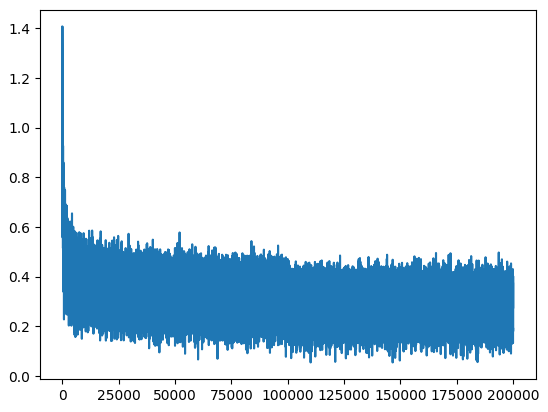

You see how the loss at the beginning is *25.4462* and then it suddenly comes down to *2.3372*?

First of all, during the training of the neural networks you always have a rough idea of **what the loss is going to be** during the **initialization of the neural network** itself.

How?\
Well it totally depends on the loss function and the problem setup.

Let's calculate what the loss in our case should we be expecting, together...

### Calculating Expected Loss

We understand that we are trying to classify the character that comes our of our neural network from our 27 characters.\
So we have no reason to believe that whatever comes out of the neural network to be more likely than the other.\
Thus, we expect that whatever comes out of our neural network is an uniform distribution, assigning all equal probabilities to all the 27 characters.


What Is the Formula for **Uniform Distribution**? \
The formula for a ***discrete uniform distribution*** is:

$$ P_x = \frac{1}{n} $$
where, $$n = \text{Number of values in the range}$$

Therefore,\
We expect loss to be roughly:
$$ P_x = \frac{1}{27} $$


And because we are doing the negetive log likelihood,\
we will have:
$$ -\log(P_x = \frac{1}{27}) $$

which is roughly:
```python
-torch.tensor(1/27.0).log()
```
```python
3.2958
```

which is much less than our original
```python
25.4462
```


**What is happening?**

Well, the neural network is currently very confident about some characters and very unconfident for some characters.\
And so it is very confidently wrong at times and that's what makes it record such high loss.

#### Let's understand this now

First let's understand how softmax works.

The softmax function is a function that turns a vector of K real values into a into a probability distribution of K real values that sum to 1.

![](https://ik.imagekit.io/botpenguin1/assets/website/Softmax_Function_07fe934386.png)

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}}$$
where $x_i$ is the $i$-th element of the input vector, and $N$ is the total number of elements in the vector.


Let's take a 4-dimensional example to understand it first

```python
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```

Output we get:
```python
Logits: tensor([0., 0., 0., 0.])
Probabilities: tensor([0.2500, 0.2500, 0.2500, 0.2500])
Loss (3rd element): tensor(1.3863)
```

This happens because:
$$\text{softmax}(0.0) = \frac{e^{0.0}}{e^{0.0} + e^{0.0} + e^{0.0} + e^{0.0}}$$

Since $e^0 = 1$, this simplifies to:

$$ \text{softmax}(0.0) = \frac{1}{1 + 1 + 1 + 1} = \frac{1}{4} = 0.25 $$

We can try changing an element to a very high number say *5*,

```python
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```

Output we get: (Very low loss)
```python
Logits: tensor([0., 0., 5., 0.])
Probabilities: tensor([0.0066, 0.0066, 0.9802, 0.0066])
Loss (3rd element): tensor(0.0200)

```

It can happen that some other logit may have this high number *(5)* and we have a normal *(0)*,

```python
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```

Output we get: (Very high loss)
```python
Logits: tensor([0., 5., 0., 0.])
Probabilities: tensor([0.0066, 0.9802, 0.0066, 0.0066])
Loss (3rd element): tensor(5.0200)
```

So the moment they start taking extreme values separate from one another,
```python
logits = torch.tensor([-3.0, 5.0, 0.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```
Output we get: (Very high loss)
```python
Logits: tensor([-3.,  5.,  0.,  0.])
Probabilities: tensor([3.3089e-04, 9.8638e-01, 6.6462e-03, 6.6462e-03])
Loss (3rd element): tensor(5.0137)
```

Makes sense, but want a `torch.randn()` example?

I've got you covered... (Keep in mind that whatever comes out of `torch.randn()` is of normal distribution)

Let's take a `torch.randn()` example,
```python
logits = torch.randn(4)
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```
Output I get: (Because the logits that come out are near 0, outputs turn out to be okay)
```python
Logits: tensor([-0.2112,  0.6164, -0.3974, -1.2911])
Probabilities: tensor([0.2243, 0.5132, 0.1862, 0.0762])
Loss (3rd element): tensor(1.6808)
```

But when we start scaling up the values,
```python
logits = torch.randn(4)  * 10
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```
Output we get: (I recorded 5 examples)
```python
Logits: tensor([-19.9521,  16.8229, -14.9549,  22.1436])
Probabilities: tensor([5.1990e-19, 4.8653e-03, 7.6947e-17, 9.9513e-01])
Loss (3rd element): tensor(37.1034)
,,,,,,,,
Logits: tensor([ -0.5194,   5.6846,  -1.0787, -13.2674])
Probabilities: tensor([2.0151e-03, 9.9683e-01, 1.1518e-03, 5.8599e-09])
Loss (3rd element): tensor(6.7665)
,,,,,,,,
Logits: tensor([  0.8513, -17.1741, -14.3672,   6.3023])
Probabilities: tensor([4.2736e-03, 6.3455e-11, 1.0507e-09, 9.9573e-01])
Loss (3rd element): tensor(20.6738)
,,,,,,,,
Logits: tensor([ -7.1875,  13.1279,  -9.7690, -14.5558])
Probabilities: tensor([1.5036e-09, 1.0000e+00, 1.1377e-10, 9.4873e-13])
Loss (3rd element): tensor(22.8969)
,,,,,,,,
Logits: tensor([-19.2067, -11.2704,  -0.9133,  14.4960])
Probabilities: tensor([2.3073e-15, 6.4536e-12, 2.0315e-07, 1.0000e+00])
Loss (3rd element): tensor(15.4093)
```

We see that because these get extreme values, it is very unlikely that our neural network will be guessing correctly.

If we start taking extreme scales like `100`, we can get:
```python
Logits: tensor([ -23.6667,  -79.3696, -102.5978,  178.2205])
Probabilities: tensor([0., 0., 0., 1.])
Loss (3rd element): tensor(inf)
```

Concluding the above examples,\
We want our logits to be equal or near 0.

And since we don't want to take any random arbitrary positive or negetive number, we want our logits to be near 0.

### Fixing Neural Network

#### Let's see where we go wrong in out neural network

Let's reinitialize our neural network and run the training for the very first iteration

In [51]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator)
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [52]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
    
    break # To run it only 1 time

      0/ 200000: 24.5937


Let's try to look at our logits now...

In [53]:
print(logits[0])

tensor([ -6.7638,  11.2628,   3.1952, -19.1932, -12.5686,  -0.1633,   6.3827,
         -3.2364,  -2.5520,  39.4363,  13.4373,   0.5839,  -8.1110,  -6.3495,
        -12.3009,   1.4096,   0.9403,  15.3641,   4.4587,  30.1650,  -0.6366,
        -17.3920,  -5.1900,  11.7134,  -9.8508, -17.1061,  -0.6482],
       grad_fn=<SelectBackward0>)


We see that they take pretty extreme values. And these logits should be very much closer to 0.

So **how can we make our logits initialize as closer to 0**?

We see that we are using:
```python
logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
```

Seems like to reduce these numbers what we can do is, we can discard the additional `bias` and scale `hiddenLayerPostActivationStates` down to a very low number...

So at initialization we can do to discard the bias is (multiplying the value with 0) and scale the hidden states to a very small number (multiplying the value with a small number),
```python
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.1
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
```


In [55]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.1
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [56]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
    
    break # To run it only 1 time
print(logits[0])

      0/ 200000: 3.9423
tensor([-0.4788, -0.8809, -0.9034, -1.2299, -3.5740, -1.2541, -0.3757,  1.8513,
         0.9006, -1.3779,  1.2780, -0.0972,  1.3983,  0.8668,  2.2659, -2.7135,
         0.0466, -0.6929,  0.3837, -1.2431,  1.4112,  1.0546,  0.3389, -1.7076,
         0.4544, -2.1233,  0.8949], grad_fn=<SelectBackward0>)


The moment we do this we see that the loss suddenly come down to something like `3.9423`\
Which is way closer to what we actually wanted (`3.2958`)

So you must be wondering what happens when we exactly set it to `0` instead of `0.1`...

In [57]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [58]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
    
    break # To run it only 1 time
print(logits[0])

      0/ 200000: 3.2958
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], grad_fn=<SelectBackward0>)


We get exactly what we'd expect: `3.2958`

But I don't use it as exactly `0`, because it can very easily *break the symmetry*.

For now let's just keep the value to be something as low as `0.01`.

So right now, we have some entropy and not exactly `0`.

So let's re run our optimization to see where we are...

#### Re-running Optimization

In [59]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [60]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.3119
  10000/ 200000: 2.5628
  20000/ 200000: 1.9610
  30000/ 200000: 2.2764
  40000/ 200000: 1.8407
  50000/ 200000: 2.2547
  60000/ 200000: 1.6596
  70000/ 200000: 1.6566
  80000/ 200000: 2.1137
  90000/ 200000: 1.5822
 100000/ 200000: 2.0502
 110000/ 200000: 1.5557
 120000/ 200000: 2.0663
 130000/ 200000: 1.7741
 140000/ 200000: 1.5805
 150000/ 200000: 1.5953
 160000/ 200000: 2.3281
 170000/ 200000: 1.9812
 180000/ 200000: 1.9841
 190000/ 200000: 1.8055


We see that our losses have scaled down pretty nicely and we are getting what we actually expect to see...

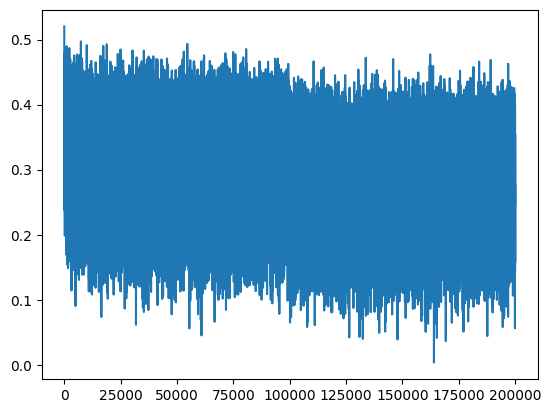

In [61]:
plt.plot(losses)

We also see that our plot of the losses now don't have the steep descent appearance.\
That is because what our optimization is *squashing* the logits down and then rearranging the logits.\
So if we took away the part of *squashing* the logits down, then we don't get these easy gains, we get the hard gains for the very first iterations...

So good things are coming up now:
1. Loss is what we expect it to be
2. Loss is coming down

```python
Original Loss: 2.0097
Loss after optimization: 1.8055
```

Why is the loss coming down you ask?

That is because, we are taking the easy part of *squashing the logits down* from the neural network, so we are **utilizing more time on optimizing** than utilizing that time in *squashing* the logits down.
